# Trends and Analysis of eCommerce Data

## CSPB 4502 Spring 2024 - Group 9

Francesca Barrios   
frba7936@colorado.edu

Laura Brown   
labr1398@colorado.edu

Seth Ely  
seel6470@colorado.edu

Darby Hansen  
daha2377@colorado.edu 

## Data Cleaning

The first step is to download the dataset into a useable format with this notebook using the Pandas library. This is easier said than done, since the data for each month is about 2 to 3 Gb each in its compressed form, and joining the data into one dataframe is causing the kernel to crash.

To begin with, we can create a sample dataset from the entire dataset locally and upload that file to our github repo.

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt


_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
# List of file names for each dataset month
local_file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

sample_df = pd.DataFrame()

for file_path in local_file_paths:
    sample_df = pd.concat([sample_df, pd.read_csv(file_path, compression='gzip').sample(n=50000)])

# Write sampled data to a new CSV file
sample_df.to_csv('./all_months_sampled.csv.gz', index=False, compression='gzip')
```

We can then find some preliminary information using this sample dataset.

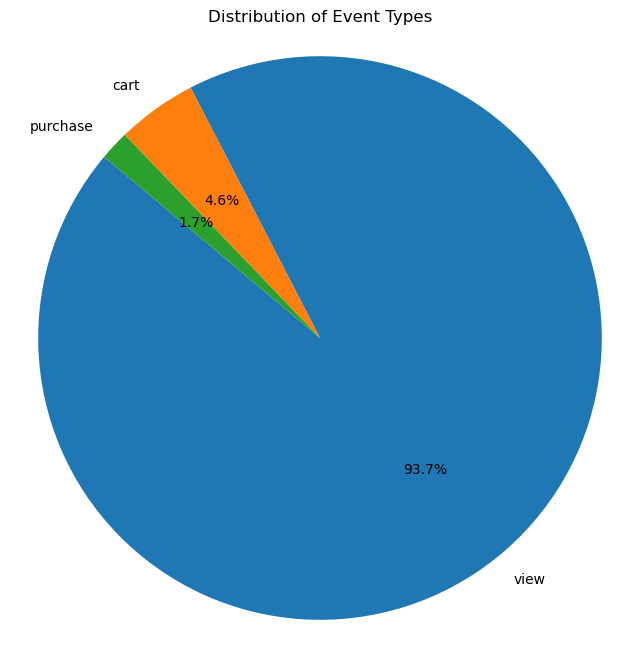

In [2]:
sample_df = pd.read_csv('./all_months_sampled.csv.gz',compression='gzip')

event_counts = sample_df['event_type'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Event Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

An important understanding of our dataset is that the event_types are mostly views, with a very minor percentage being purchases. Since most of our questions involve looking specifically at purchases, we can use this information to reduce the dataset to a more managable size. We can iterate through each local file again, this time only taking entries where the event_types are 'purchase'

_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
purchased_entries = pd.DataFrame()

# List of file names for each month
file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

for file_path in file_paths:
    cur_df = pd.read_csv(file_path, compression='gzip')
    purchased_entries = pd.concat([purchased_entries, cur_df[cur_df['event_type'] == 'purchase']], ignore_index=True)


# Write to csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip')
```

This dataframe is still fairly massive and might need to be iterated over in chunks to avoid overflowing memory in online environments especially. Because of this, we can use the 'chunksize' attribute of pd.read_csv to iterate over it in chunks. Let's do this to gain further insight about NaN values

In [4]:
chunksize = 100000

nan_accum = pd.Series(dtype='float64')
len_accum = 0
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    len_accum += len(chunk)
    nan_accum = nan_accum.add(chunk.isnull().sum(), fill_value=0)

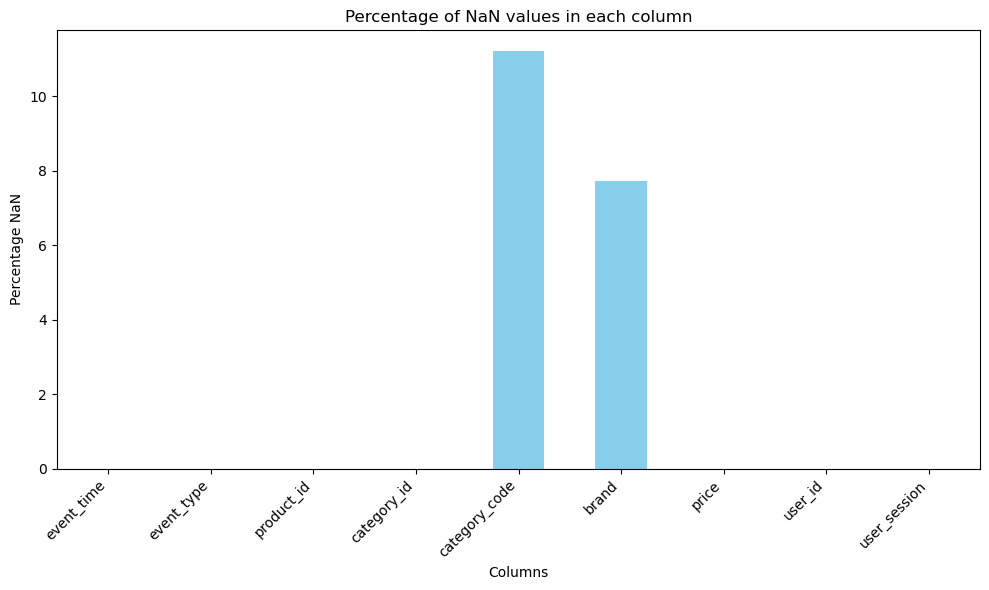

There are 4.0 user_session NaNs


In [5]:
plt.figure(figsize=(10, 6))
(100* nan_accum/len_accum).plot(kind='bar', color='skyblue')
plt.title('Percentage of NaN values in each column')
plt.xlabel('Columns')
plt.ylabel('Percentage NaN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print('There are',nan_accum['user_session'],'user_session NaNs')

We can see that 7.7% of all brands are made up by NaN values and 11% of category codes are NaNs. There are a very small amount of user_session data points that are NaN as well, but these are negligible. It would be helpful to determine how many entries have both NaN category_codes and NaN brand features.

In [6]:
chunksize = 100000
cat_and_brand_nans = 0
len_accum = 0

# Iterate through the CSV file in chunks
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    # Count the total number of rows in the chunk
    len_accum += len(chunk)
    
    # Filter the chunk to include only rows where both 'category_code' and 'brand' are NaN
    cat_and_brand_nans += (chunk['category_code'].isna() & chunk['brand'].isna()).sum()


In [7]:
brand_no_cat = nan_accum['category_code']-cat_and_brand_nans
cat_no_brand = nan_accum['brand']-cat_and_brand_nans
valid_brand_and_cat = len_accum - (brand_no_cat+cat_no_brand+cat_and_brand_nans)
table = pd.DataFrame(
    {
        'Valid category_code': [valid_brand_and_cat, nan_accum['brand']-cat_and_brand_nans],
        'NaN category_code': [brand_no_cat,cat_and_brand_nans]
    },
    index=['Valid brand','NaN brand']
)
table['Total'] = table.sum(axis=1)
table.loc['Total'] = table.sum(axis=0)
table.applymap('{:,.0f}'.format)

,Valid category_code,NaN category_code,Total
Valid brand,"5,707,926","611,751","6,319,677"
NaN brand,"372,838","156,309","529,147"
Total,"6,080,764","768,060","6,848,824"


In [8]:
# create dataframe to show this as a 2x2 table (columns not NaN, Nan; rows: category_code, brand)

print('percentage across all category_code NaNs that also have NaN brand:',100* cat_and_brand_nans / nan_accum['category_code'],'%')
print('percentage across all Brand values that have a NaN value and a valid category_code:', 100*(nan_accum['brand'] - cat_and_brand_nans)/ len_accum,'%')
print('percentage across all category_code values that have a NaN value and a valid brand value:', 100*(nan_accum['category_code'] - cat_and_brand_nans)/ len_accum,'%')

percentage across all category_code NaNs that also have NaN brand: 20.351144441840482 %
percentage across all Brand values that have a NaN value and a valid category_code: 5.443825100484404 %
percentage across all category_code values that have a NaN value and a valid brand value: 8.932205003369921 %


It looks like 20% of the category_code NaN entries also do not have the brand value. Since these entries would have only the product_id to go off of (a numerical categorical value that has little meaning) we can safely drop these values as they would have little information for us.

With this in mind, only 5% of all remaining brand entries will have valid category codes and only 9% of all remaining category_code entries will have a valid brand value. Because of this, we may be able to remove any NaNs for category_code, brand, and user_session while still retaining a vast majority of the variability of our data.

Our group discussed the relevance of the user_id and user_session features as they would not be relevant to many of the questions we are seeking to answer. Furthermore, the product_id feature seems to hold a numerical value, which without knowing what online vendor this data is from, is not very helpful in determining the associated product.

_(this code seems to not work in the online version of JupyterHub, but it can be run offline)_
```python
purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=100000):
    purchased_entries = pd.concat([purchased_entries, chunk.drop(columns=['user_id','user_session','product_id']).dropna()])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip', index=False)
```

We will also need to convert the event_time column from a string data type to a datetime type to gain insight into purchases over time and be able to create graphs using this column.

```python
purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=100000):
    # Convert 'event_time' column to datetime format
    chunk['event_time'] = pd.to_datetime(chunk['event_time'])
    purchased_entries = pd.concat([purchased_entries, chunk])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries_clean.csv.gz', compression='gzip', index=False)
```

With these changes, our data is now clean and ready to be worked with.

In [31]:
cleaned_dataset_head = pd.read_csv('./purchased_entries_clean.csv.gz', chunksize=5).get_chunk()
cleaned_dataset_head

,event_time,event_type,category_id,category_code,brand,price
0,2019-10-01 00:02:14+00:00,purchase,2053013555631882655,electronics.smartphone,samsung,130.76
1,2019-10-01 00:04:37+00:00,purchase,2053013555631882655,electronics.smartphone,apple,642.69
2,2019-10-01 00:07:07+00:00,purchase,2053013557418656265,furniture.bathroom.toilet,santeri,54.42
3,2019-10-01 00:09:26+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,189.91
4,2019-10-01 00:09:54+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,161.98


# Since the cleaned csv.gz file cannot be uploaded, we have provided a [link to it here](https://o365coloradoedu-my.sharepoint.com/:u:/g/personal/seel6470_colorado_edu/ESA7CLIV9o9GofliJhF4M7kBY_G1lR-JuUPj6CaiO0OQBg?e=XSJqss)

___________________________________

# Analysis of the Cleaned Data

## Which brands, or item categories, exhibit the highest volume of sales and profits during the specified period?
Now that the data has been cleaned we can create an accurate dataframe with the categoy codes and brands for all entries. Below we have created a frequency bar plot for the data. Since we are looking at which item/brand has the highest frequency, the visualizations have been truncated to the top results to improve clarity.

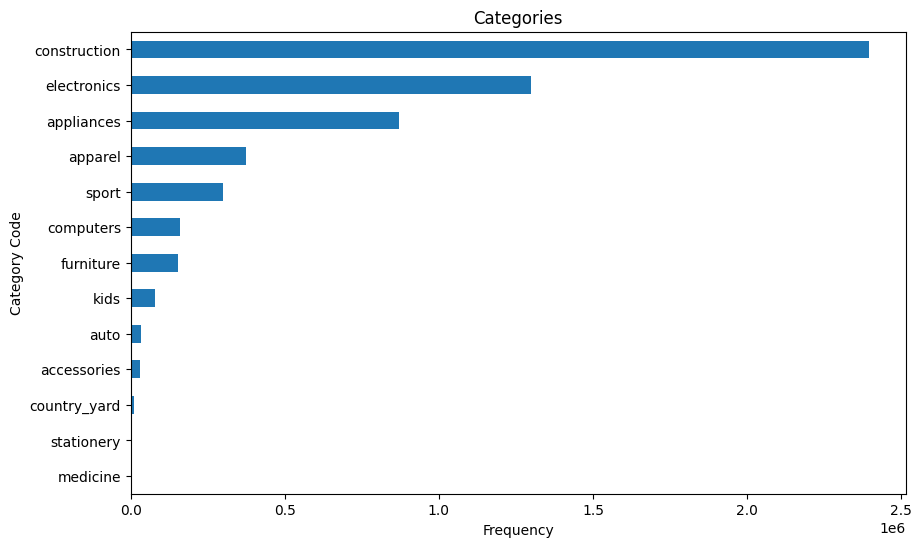

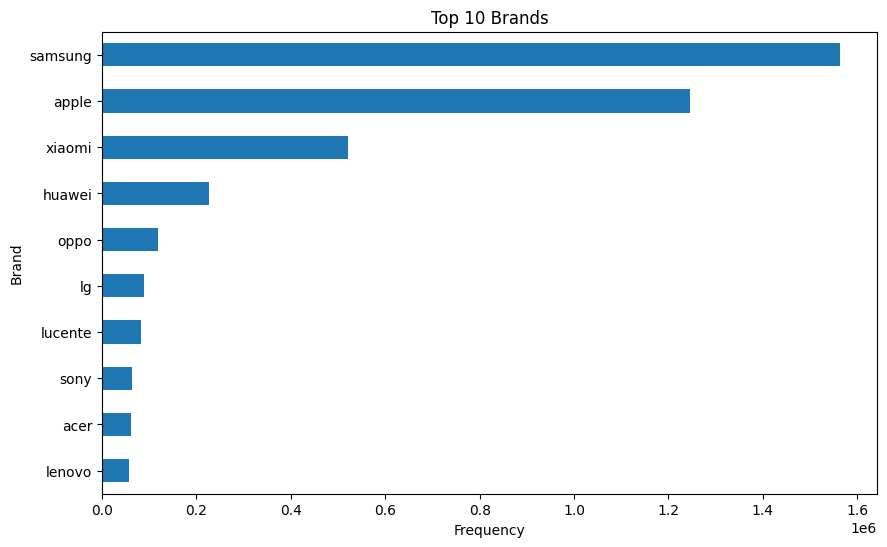

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#initialize dataframe of the cleaned data
df = pd.read_csv('./purchased_entries_clean.csv.gz')

# Calculate the frequency of each category code
#category_counts = df['category_code'].value_counts()
df['main_category'] = df['category_code'].str.split('.').str[0]

# Group by 'main_category' and count occurrences
category_counts = df.groupby('main_category').value_counts()
sorted_categories = category_counts.sort_values(ascending=False)

# Calculate the frequency of each category code
df['main_category'] = df['category_code'].str.split('.').str[0]

# Group by 'main_category' and count occurrences
category_counts = df['main_category'].value_counts()

# Sort the category counts by frequency in descending order
category_counts_sorted = category_counts.sort_values(ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
category_counts_sorted.plot(kind='barh')
plt.title('Categories')
plt.xlabel('Frequency')
plt.ylabel('Category Code')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()

# Calculate the frequency of each brand
brand_counts = df['brand'].value_counts()

#truncate values to top values
top_brands = brand_counts.head(10)

#Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
top_brands.plot(kind='barh')
plt.title('Top 10 Brands')
plt.xlabel('Frequency')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()

From the first plot we can see the plurality of all purchases, in regards to item category, over the seven month period is the construction category. The second closest is electronics followed by appliances. We can draw a couple implications from these categories being the top three. The electronic and appliance categories can often be considered essential purchases. Customers regularly invest in these categories to meet basic needs and their high frequency shows the significance in a consumer market. Construction being the top category indicates a high demand in long term investment. There is currently a sustained demand for these kinds of materials as new homes, apartments, and businesses are constantly being built. 

In the second plot it is clear that Samsung has the highest volume of sales, closely followed by Apple products. Most of the brands in the top ten shown are elctronic brands. Because of this we can easily determine that Samsung and Apple account for the greatest proportion of sales for electronics. This is most likely due to strong brand recognition and popular product offerings. 

It is interesting that the first chart shows construction having the higher frequency and electronics second when the brands chart shows almost all electronic brands. One reason for this is people may be buying construction materials and electronics simultaneously which would indicate a correlation between the two. Another possibility is there may be anomolies or biases in the data that are causing a skew in the results.

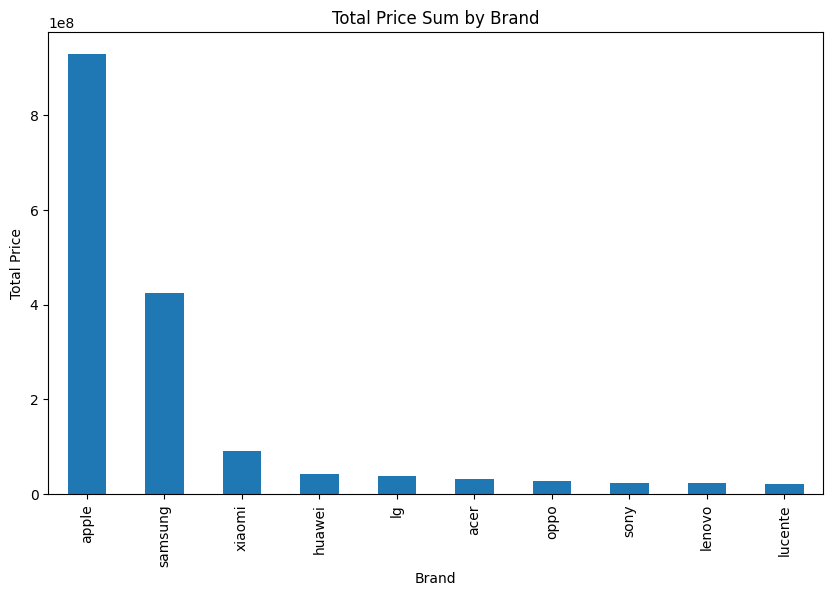

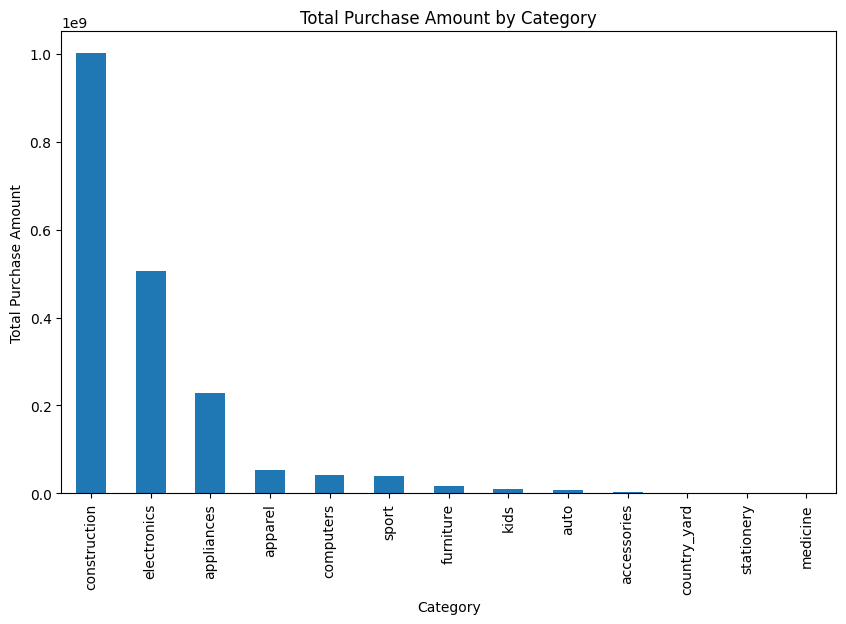

In [6]:
import matplotlib.pyplot as plt

# Group by 'brand' and calculate the sum of 'price'
brand_grouped = df.groupby('brand')['price'].sum().sort_values(ascending = False)
most_profitable_brand = brand_grouped.head(10)

# Group by 'category_code' and calculate the sum of 'price'

category_grouped = df.groupby('main_category')['price'].sum().sort_values(ascending = False)

# Plot for most profitable brand
plt.figure(figsize=(10, 6))
most_profitable_brand.plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Total Price')
plt.title('Total Price Sum by Brand')
plt.show()


# Plot for most profitable category
plt.figure(figsize=(10, 6))
#most_profitable_category.plot(kind='bar')
category_grouped.plot(kind='bar')
plt.title('Total Purchase Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Purchase Amount')
plt.show()

In these plots, the Apple brand and the construction category have the highest profit over the time period. This is not a surprising finding as construction has the highest category frequency. For the brands, when comparing highest sales to highest profits, Apple and Samsung have switched places. This implies that while Samsung has a greater number of sales, Apple has more expensive products giving them a higher profit.

We can increase the granularity of the category codes by taking the full category and plot to see if we can gain any more specific insights:

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

running_sum = pd.Series(dtype=float)

for chunk in pd.read_csv('./purchased_entries_clean.csv.gz', chunksize = 100000):
    running_sum = running_sum.add(chunk.groupby('category_code')['price'].sum(),fill_value=0)

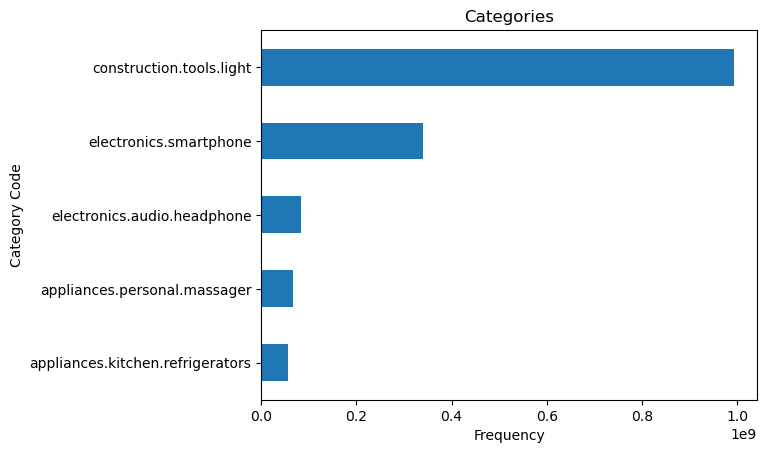

In [33]:
running_sum = running_sum.sort_values(ascending=False)

running_sum.head().plot(kind='barh')
plt.title('Categories')
plt.xlabel('Frequency')
plt.ylabel('Category Code')
plt.gca().invert_yaxis()
plt.show()

We can see that hands down, construction.tools.light is the highest revenue producer. This would indicate this eCommerce marketplace possibly specializes in flashlights or industrial flood lighting that are popular in construction use. Let's delve further to see what the price points for this product are in this category, as well as how many products per price point were sold.

In [38]:
flashlight_sales = pd.Series(dtype=float) # hold all unique price points

for chunk in pd.read_csv('./purchased_entries_clean.csv.gz', chunksize = 100000):
    flashlights = chunk[chunk['category_code'] == 'construction.tools.light']
    flashlight_sales = flashlight_sales.add(flashlights.groupby('price')['price'].size(), fill_value=0)

flashlight_sales = flashlight_sales.sort_values(ascending=False)

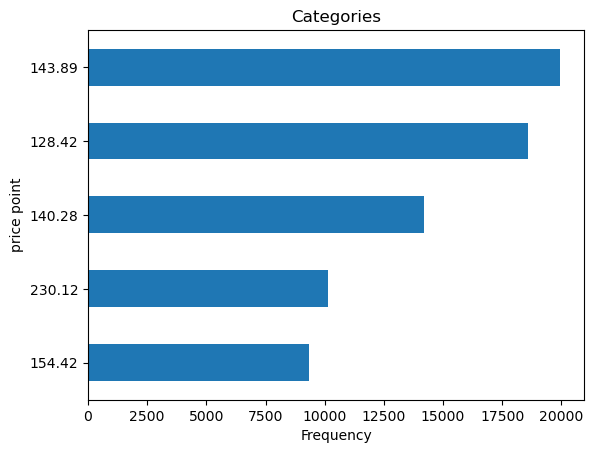

Maximum Price: 2562.49
Minimum Price: 1.85


In [43]:
flashlight_sales.head().plot(kind='barh')
plt.title('Categories')
plt.xlabel('Frequency')
plt.ylabel('price point')
plt.gca().invert_yaxis()
plt.show()

max_price = flashlight_sales.index.max()
min_price = flashlight_sales.index.min()

print("Maximum Price:", max_price)
print("Minimum Price:", min_price)

We can see that the highest selling items are around $150 with around 20000 units sold. This indicates that it is the quantity of this category that leads to the highest revenue.

Sorting in the opposite direction below, we can see that the lowest revenue producing items are those from the stationary.paper cateogory, with some computer components and a specific category for axes used in construction. These insights could help the eCommerce company focus their efforts to continue to drive sales for their big revenue producers and spend less time on their lowest revenue producers.

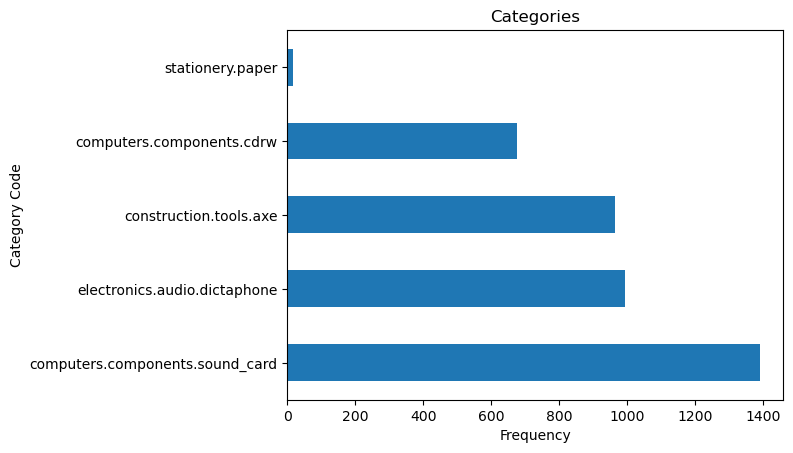

In [41]:
running_sum = running_sum.sort_values(ascending=True)

running_sum.head().plot(kind='barh')
plt.title('Categories')
plt.xlabel('Frequency')
plt.ylabel('Category Code')
plt.gca().invert_yaxis()  # Invert y-axis to display lowest frequency at the top
plt.show()

After grouping the data by brand and category code, we took the total sum for each and compared them to the other brands and categories. The visualizations above show that the most profitable brand is Apple and the most profitable category code is construction.tools.light.

### Are there discernible trends in sales across different brands and categories over the 7 month period? 

First we convert the 'event_time' category into a true datetime format.

In [8]:
# turn event_time into true datetime format
df['event_time'] = pd.to_datetime(df['event_time'])

# create two new columns, date and time with parsed data
df['date'] = df['event_time'].dt.date
df['time'] = df['event_time'].dt.time
df.head()

,event_time,event_type,category_id,category_code,brand,price,main_category,date,time
0,2019-10-01 00:02:14+00:00,purchase,2053013555631882655,electronics.smartphone,samsung,130.76,electronics,2019-10-01,00:02:14
1,2019-10-01 00:04:37+00:00,purchase,2053013555631882655,electronics.smartphone,apple,642.69,electronics,2019-10-01,00:04:37
2,2019-10-01 00:07:07+00:00,purchase,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,furniture,2019-10-01,00:07:07
3,2019-10-01 00:09:26+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,189.91,electronics,2019-10-01,00:09:26
4,2019-10-01 00:09:54+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,161.98,electronics,2019-10-01,00:09:54


### Among brands and categories, how do profits fluctuate over the 7 month time frame? 

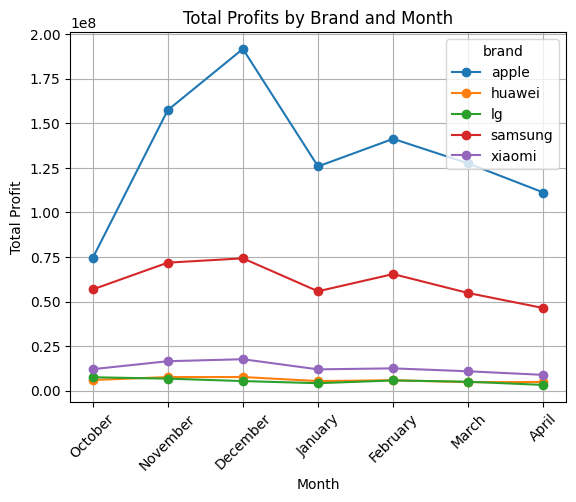

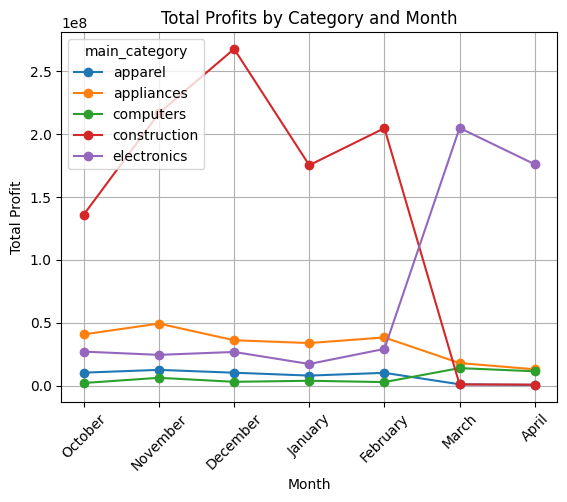

In [9]:
# Extract month from date column
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
# List months in order from Oct 2019 to April 2020
months_ordered = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

# Plot most profitable brand purchases over time
# For brand_grouped truncated brands to 5 most profitable brands
most_profitable_5_brands = brand_grouped.head(5)

# Extract months
df_top_5_brands = df[df['brand'].isin(most_profitable_5_brands.index)]
df_top_5_brands.loc[:, 'month'] = df_top_5_brands['date'].dt.strftime('%B')  # Full month name

# Group by brand and month and calculate the sum of price
brand_monthly_total = df_top_5_brands.groupby(['brand', 'month'])['price'].sum().reset_index()

# Creates a dataframe suitable for plotting
pivot_df_brands = brand_monthly_total.pivot(index='month', columns='brand', values='price')
pivot_df_brands.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.title('Total Profits by Brand and Month')
plt.xticks(range(len(months_ordered)), months_ordered, rotation=45) 
plt.grid(True)
plt.show()


# Plot most profitable category purchases over time

# Truncate for readability
most_profitable_5_categories = category_grouped.head(5)

# Extract months
df_top_5_categories = df[df['main_category'].isin(most_profitable_5_categories.index)]
df_top_5_categories.loc[:, 'month'] = df_top_5_categories['date'].dt.strftime('%B')

category_monthly_total = df_top_5_categories.groupby(['main_category', 'month'])['price'].sum().reset_index()

pivot_df_categories = category_monthly_total.pivot(index='month', columns='main_category', values='price')
pivot_df_categories.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.title('Total Profits by Category and Month')
plt.xticks(range(len(months_ordered)), months_ordered, rotation=45) 
plt.grid(True)
plt.show()

In the plots above, the top five grossing brands and categories are plotted. In both, the top two grossing categories and brands have the highest degree of change while the other have very little change. For the brand plot, the lines representing Apple and Samsung both experience a peak in December. This is not surprising as that is during the holidays and products from those brands are frequently bought as gifts. In the category plot, the line representing the construction category also experiences a peak in December with a significant drop from February to March. When looking at the line for electronics, it is surprising to see that the profits are fairly low until March when it experiences a significant jump. This is interesting seeing as the most profitable brands are electronics and they reach their peak in December.

## What Categories/Brands have the highest purchases per view?

This question requires the raw data, since we will need both views and purchases. The following code was run offline on the full dataset in chunks to produce csv files with unique brands/categories and their respective counts for views and purchases.

```python
brand_purchase_counts = pd.Series(dtype=float)
brand_view_counts = pd.Series(dtype=float)
category_purchase_counts = pd.Series(dtype=float)
category_view_counts = pd.Series(dtype=float)

# List of file names for each month
file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

for file_path in file_paths:
    print('running', file_path)
    for chunk in pd.read_csv(file_path, compression='gzip', chunksize=500000):
        brands = chunk.groupby('brand')['event_type']
        categories = chunk.groupby('category_code')['event_type']
        brand_purchases = brands.apply(lambda x: (x == 'purchase').sum())
        brand_views = brands.apply(lambda x: (x == 'view').sum())
        cat_purchases = categories.apply(lambda x: (x == 'purchase').sum())
        cat_views = categories.apply(lambda x: (x == 'view').sum())
        brand_purchase_counts = brand_purchase_counts.add(brand_purchases, fill_value=0)
        brand_view_counts = brand_view_counts.add(brand_views, fill_value=0)
        category_purchase_counts = category_purchase_counts.add(cat_purchases, fill_value=0)
        category_view_counts = category_view_counts.add(cat_views, fill_value=0)

brands_csv = pd.DataFrame({'brand': brand_purchase_counts.index,
                   'total_purchases': brand_purchase_counts.values,
                   'total_views': brand_view_counts.values})

cat_csv = pd.DataFrame({'brand': category_purchase_counts.index,
                   'total_purchases': category_purchase_counts.values,
                   'total_views': category_view_counts.values})

# Write to csv.gz
brands_csv.to_csv('brand_counts.csv.gz', compression='gzip')
cat_csv.to_csv('category_counts.csv.gz', compression='gzip')
```

In [46]:
brand_counts = pd.read_csv('./brand_counts.csv.gz',compression='gzip')
category_counts = pd.read_csv('./category_counts.csv.gz',compression='gzip')

In [51]:
category_counts.head()

,Unnamed: 0,brand,total_purchases,total_views
0,0,accessories.bag,25146.0,3431550.0
1,1,accessories.umbrella,1309.0,267964.0
2,2,accessories.wallet,10399.0,1106654.0
3,3,apparel.belt,154.0,17577.0
4,4,apparel.costume,23026.0,2380528.0


In [52]:
brand_counts['purchase_view_ratio'] = brand_counts['total_purchases'] / brand_counts['total_views']
category_counts['purchase_view_ratio'] = category_counts['total_purchases'] / category_counts['total_views']

In [55]:
category_counts.sort_values(by='purchase_view_ratio',ascending=False).head()

,Unnamed: 0,brand,total_purchases,total_views,purchase_view_ratio
140,140,stationery.paper,6.0,120.0,0.050000
88,88,construction.tools.light,2313086.0,66149325.0,0.034968
109,109,electronics.smartphone,734123.0,27110854.0,0.027079
133,133,sport.bicycle,263991.0,10024203.0,0.026335
25,25,apparel.trousers,20404.0,805220.0,0.025340


Interestingly, we can see that the lowest revenue producer, stationery.paper, has the highest purchases per view. Most people must intentional visit these pages to purchase, as opposed to browsing for leisure. The second highest category is the construction.tools.light followed by the electronics.smartphone cateogries, continuing to further the narrative that these two categories are the most popular found on this eCommerce vendor's website.

In [59]:
brand_counts.sort_values(by='purchase_view_ratio',ascending=False).head(10)

,brand,total_purchases,total_views,purchase_view_ratio
1541,dotemu,1.0,2.0,0.500000
4197,orbit,3.0,7.0,0.428571
6220,yan,6.0,17.0,0.352941
4,a-product,6.0,17.0,0.352941
698,benuta,1.0,3.0,0.333333
758,bio,1.0,3.0,0.333333
5816,ulker,4.0,12.0,0.333333
5513,tassay,2.0,7.0,0.285714
1130,chocair,2.0,8.0,0.250000
1021,capri-sonne,1.0,4.0,0.250000


Also surprisingly, the highest purchase per view brands are brands with very low views and purchases. Let's filter for brands that have high views/purchases.

In [62]:
brand_counts[(brand_counts['total_purchases'] > 1000) & (brand_counts['total_views'] > 1000)].sort_values(by='purchase_view_ratio',ascending=False).head(10)

,brand,total_purchases,total_views,purchase_view_ratio
2659,iqos,9766.0,172055.0,0.056761
1609,ea,1933.0,37707.0,0.051264
5594,thermomix,3257.0,81311.0,0.040056
305,apple,1246326.0,31190061.0,0.039959
2520,huggies,4711.0,123725.0,0.038076
2196,glo,5174.0,142146.0,0.036399
4927,samsung,1567074.0,44902302.0,0.034900
725,bestoy,2236.0,74198.0,0.030136
2951,kirkland,1002.0,33472.0,0.029935
1245,cordiant,55816.0,1901533.0,0.029353


Here we can see Apple and Samsung lower in our list, but the highest brands are IQOS, EA, and Thermomix, with Huggies closely following Apple. These could be brands the eCommerce vendor may want to understand further as to why users may be more likely to be intentional about visiting the product page to purchase. The figures could indicate the popularity of the brand/category from above, or possibly that the search engine optimization causes more users to be directed to these pages. Another interpretation to look into would be whether or not the products in these categories/brands are unique to this eCommerce site, contributing to more people coming to them specifically to purchase rather than view.

## Evaluation

### Accuracy

A useful insight into this data set would be to create a cluster algorithm to create groups of similar products. This could be helpful to determine a recommendation list on any given product page based on products that are also in the same cluster as the product being viewed.

We can do this using the K-Means algorithm with all category_code and brand pairings. First, let us get a list of all unique category_codes as well as brands:

Let's use the indices of each value to enable us to visualize the data points in our cleaned data set in a coordinate plane.

In [55]:
unique_value_pairs = pd.DataFrame()
for chunk in pd.read_csv('./purchased_entries_clean.csv.gz', compression='gzip', chunksize=100000):
    unique_value_pairs = pd.concat([unique_value_pairs, chunk[['category_code', 'brand']].drop_duplicates()])

In [56]:
unique_value_pairs

,category_code,brand
0,electronics.smartphone,samsung
1,electronics.smartphone,apple
2,furniture.bathroom.toilet,santeri
3,electronics.audio.headphone,apple
6,appliances.environment.air_heater,oasis
...,...,...
5707822,apparel.shoes,panasonic
5707829,construction.tools.welding,rock
5707830,electronics.camera.photo,xiaomi
5707875,apparel.shoes.keds,peg-perego


Since similar brands will be close together, and similar category_codes will be close together, let's assing numerical values based on alphabetical order that will allow us to visualize the two feature set in a coordinate plane.

In [57]:
x_axis_categories = unique_value_pairs['category_code'].unique()
x_axis_categories.sort()
x_axis_categories = pd.DataFrame(x_axis_categories,columns=['category_code'])
x_axis_categories

,category_code
0,accessories.bag
1,accessories.umbrella
2,accessories.wallet
3,apparel.belt
4,apparel.costume
...,...
134,sport.snowboard
135,sport.tennis
136,sport.trainer
137,stationery.cartrige


In [58]:
y_axis_brands = unique_value_pairs['brand'].unique()
y_axis_brands.sort()
y_axis_brands = pd.DataFrame(y_axis_brands,columns=['brand'])
y_axis_brands

,brand
0,a-case
1,a-derma
2,a-elita
3,a-mega
4,a-toys
...,...
4076,zte
4077,zubr
4078,zuru
4079,zvezda


In [68]:
import numpy as np

x_axis_categories = x_axis_categories.to_numpy().flatten()
y_axis_brands = y_axis_brands.to_numpy().flatten()

In [73]:
x_values = np.array([])
y_values = np.array([])
x_y_values = np.array([])

for index, row in unique_value_pairs.iterrows():
    x = np.argwhere(x_axis_categories == row[0]).flatten()
    y = np.argwhere(y_axis_brands == row[1]).flatten()
    x_values = np.append(x_values, x)
    y_values = np.append(y_values, y)
    x_y_values = np.append(x_y_values, np.array([x, y]))

# Reshape x_values and y_values to match the expected shape
x_values = x_values.reshape(-1)
y_values = y_values.reshape(-1)

# Reshape x_y_values to be a 2D array
x_y_values = x_y_values.reshape(-1, 2)

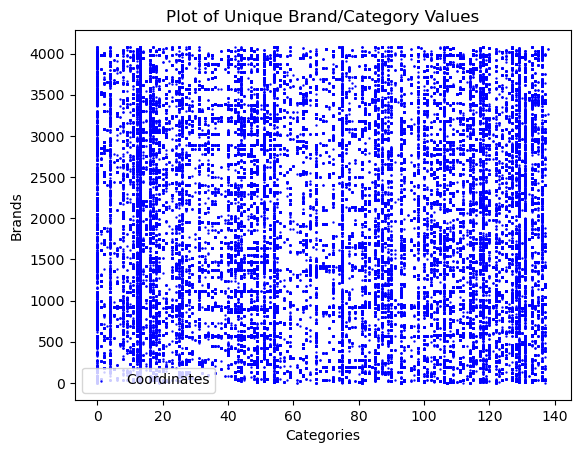

In [74]:
plt.scatter(x_values, y_values, color='blue', label='Coordinates', s=0.5)
plt.xlabel('Categories')
plt.ylabel('Brands')
plt.title('Plot of Unique Brand/Category Values')
plt.legend()
plt.show()

We can see from this visualization that there are some categories that have products associated with almost every brand. These would be represented as vertical lines. We also have a very wide spread of brands/categories that is very dense. K Means will likely create groups that are similar in size, but let us see what we are able to create.

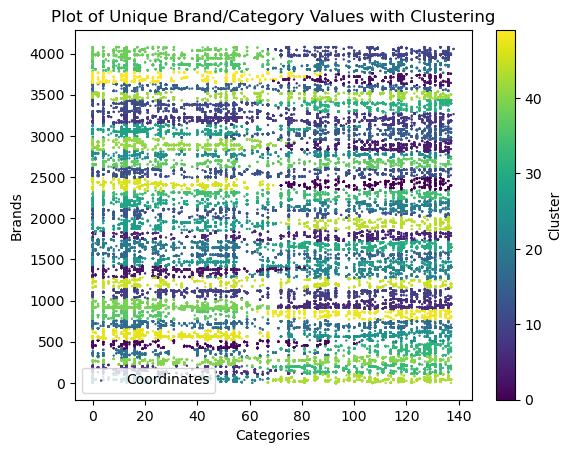

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Perform K-means clustering
kmeans = KMeans(n_clusters=50,n_init='auto')  # Number of clusters
kmeans.fit(x_y_values)

# Get cluster labels
cluster_labels = kmeans.labels_

# Plot the scatter plot with corresponding color labels
plt.scatter(x_values, y_values, c=cluster_labels, cmap='viridis', label='Coordinates', s=0.5)
plt.xlabel('Categories')
plt.ylabel('Brands')
plt.title('Plot of Unique Brand/Category Values with Clustering')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

As you can see, the clustering algorithm seems to prioritize horizontal relationships, representing the different categories amond. This may be because brands might sell products in neighboring categories, whereas clustering by categories might not present as much similarity.

Given the output of the K-Means algorithm, we would easily be able to create a new characteristic for each product representing it's associated cluster, and a random generator could be used to retrieve several items belonging to the same cluster as the product being viewed.

### Relevance

After analyzing the data, it became evident that certain brands and item categories stand out in terms of both sales volume and profitability.These findings can help this company do better in catering to their customers. By knowing which brands and categories have the highest sales and profits, they can allocate resources, such as marketing budgets and inventory, more effectively by focusing on the products that generate the highest returns. They can also prioritize innovation and investment in products within these categories to capitalize on consumer demand and preferences. The seasonal trends observed can also help with this. Seeing where different categories jump in profits will help the company focus on when to promote products within those categories.

The K-means algorithm is useful in predicting products similar to what is being viewed. It can suggest other products within the same category or other items that were frequently bought with the currently viewed item. The company can use it to entice users to buy more items or help them find similar items that are a different brand or price. It will help improve the customer's shopping experience and their satisfaction. By predicting products, it can help guide them to products they might not have found otherwise and increase the probability of a purchase.


### Interpretability

_discuss visualizations and how understandable the findings are to the general public_